# Hotel Rating Prediction Using Recurrent Neural Network

Name : Happy Trianna\
Batch : FTDS RMT 018

## Objective


- Menganalisis karakteristik pengunjung hotel di London
-   Menganalisis review yang diberikan terhadap hotel yang ada di London
-   Mencari model terbaik untuk memprediksikan rating review pengunjung hotel di London



## Data

Data yang digunakan adalah data `London_hotel_reviews` yang didapat dari kaggle.

## Import Libraries

In [1]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 33.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=505ca7677af03ef495d66c08d9ffccf76899bf40a66a696da15248ba3282db63
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
!pip install spacytextblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.5/636.5 KB 42.9 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1


In [4]:
import numpy as np
import pandas as pd
import re
import time
import random

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.compat.v1.keras.layers import GRU
from tensorflow.compat.v1.keras.layers import LSTM

# Count words
from collections import Counter
from collections import OrderedDict

#WordCloud
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from langdetect import detect

import string
import itertools
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Model, Sequential

# Model Evaluation of test-set
from sklearn.metrics import classification_report

import warnings as wrn

In [5]:
# Download package nltk
nltk.download(['stopwords', 'punkt','averaged_perceptron_tagger',
               'vader_lexicon', 'wordnet', 'omw-1.4'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Data Loading

In [34]:
# Read the data as df
df = pd.read_csv('https://raw.githubusercontent.com/TriannaHappy/FTDS_test1/main/London_hotel_reviews.csv', encoding = "ISO-8859-1")

# Viewing the shape and the head of the data
print(df.shape)
df.head()

(27330, 6)


,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review
0,Apex London Wall Hotel,5,Ottima qualità prezzo,Siamo stati a Londra per un week end ed abbiam...,"Casale Monferrato, Italy",10/20/2012
1,Corinthia Hotel London,5,"By far, my best hotel in the world",I had a pleasure of staying in this hotel for ...,"Savannah, Georgia",3/23/2016
2,The Savoy,5,First visit to the American Bar at the Savoy,A very lovely first visit to this iconic hotel...,London,7/30/2013
3,Rhodes Hotel,4,Nice stay,3 of us stayed at the Rhodes Hotel for 4 night...,"Maui, Hawaii",6/2/2012
4,The Savoy,5,Perfection,Form the moment we arrived until we left we ex...,"London, United Kingdom",11/24/2017


In [7]:
# Viewing the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27330 entries, 0 to 27329
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Property Name             27330 non-null  object
 1   Review Rating             27330 non-null  int64 
 2   Review Title              27330 non-null  object
 3   Review Text               27330 non-null  object
 4   Location Of The Reviewer  23377 non-null  object
 5   Date Of Review            27329 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.3+ MB


In [50]:
# Change date type into datetime type
df['Date Of Review']=pd.to_datetime(df['Date Of Review'])

In [9]:
# Get the rate and review text only to be analyzed
data=df[['Review Rating', 'Review Text' ]]
data.rename({'Review Rating': 'rate', 'Review Text': 'text'}, axis=1, inplace=True)
data

<ipython-input-9-784685482b25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename({'Review Rating': 'rate', 'Review Text': 'text'}, axis=1, inplace=True)


,rate,text
0,5,Siamo stati a Londra per un week end ed abbiam...
1,5,I had a pleasure of staying in this hotel for ...
2,5,A very lovely first visit to this iconic hotel...
3,4,3 of us stayed at the Rhodes Hotel for 4 night...
4,5,Form the moment we arrived until we left we ex...
...,...,...
27325,5,I come to London often but since I stayed in t...
27326,3,En cuarto que nos tocó no había toallas y habí...
27327,4,This is a quality quiet hotel located in an ex...
27328,4,"Väldigt vackra rum, tyvärr med en mycket höglj..."


In [ ]:
# Function to detect language of text in a given row
def detect_language(row):
    return detect(row['text'])

# Add a new column with the language of each text
data['language'] = data.apply(detect_language, axis=1)

# Filter out non-English rows and drop the 'language' column
data_eng = data.loc[data['language'] == 'en'].drop('language', axis=1)


In [ ]:
# reset index
data_eng.reset_index(drop=True, inplace=True)

In [12]:
# Check the shape of non english review
data_neng = [sentence for sentence in data.text if detect(sentence) != 'en']

data.shape, np.shape(data_neng)

((27330, 3), (3751,))

Hanya **3751** data yang tidak dimasukkan ke dalam analisis kali ini, dari **27330** data.

## Exploratory Data Analysis

### Undersampling

In [140]:
# Check the distribution of the target
data_eng.rate.value_counts()

5    16341
4     4788
3     1370
2      579
1      499
Name: rate, dtype: int64

Terdapat imbalanced pada data target sehingga akan dilakukan oversampling. Data yang dengan kategori di bawah 3 (rate 1-2) diasumsikan memiliki karakteristik yang bersentimen negatif jika dibandingkan dengan rate 3 ke atas, sehingga sebelum dilakukan undersampling, rate 1-2 akan di-merge terlebih dahulu.

In [14]:
# Merge class 1-2 into 0, 3 into 1, 4 into 2, and 5 into 3

data_eng['label'] = data_eng['rate'].replace({5 : 3, 4 : 2, 3 : 1, 2 : 0, 1 : 0})
data_eng

,rate,text,label
0,5,I had a pleasure of staying in this hotel for ...,3
1,5,A very lovely first visit to this iconic hotel...,3
2,4,3 of us stayed at the Rhodes Hotel for 4 night...,2
3,5,Form the moment we arrived until we left we ex...,3
4,1,Well I am no strange to London's 5star hotels ...,0
...,...,...,...
23572,5,Recently came here for a friends birthday. We ...,3
23573,4,Greatly located with lovely views of the park ...,2
23574,5,I come to London often but since I stayed in t...,3
23575,4,This is a quality quiet hotel located in an ex...,2


In [15]:
# Undersampling the label of the data
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
X, y = rus.fit_resample(data_eng.text.to_numpy().reshape(-1,1), data_eng.label)

y.value_counts()

0    1078
1    1078
2    1078
3    1078
Name: label, dtype: int64

Sekarang semua nilai y (target) sudah terdistribusi merata.

In [16]:
# Create new dataframe from undersampled data
df_eda=pd.DataFrame({'text' : X.reshape(-1), 'rate': y})
df_eda

,text,rate
0,Well I am no strange to London's 5star hotels ...,0
1,was so looking forward to staying here had hig...,0
2,I had always wanted to stay at The Dorchester....,0
3,Having tried the Dorchester hotel in LA and Pa...,0
4,Wow what a disappointment! Booked this hotel t...,0
...,...,...
4307,Outstanding property. The staff are very helpf...,3
4308,Overnight stay for shopping and spa. Absolutel...,3
4309,We stayed at the Xenia in Kensington for the f...,3
4310,"I had taken a brief to London, while assisting...",3


Sebelum masuk ke EDA, akan dilakukan pengecekan terlebih dahulu terhadap data yang terduplikasi. Pada kali ini akan dilakukan eda terhadap data sebelum dilakukan undersampling dan sesudah. Tujuannya adalah agar kami dapat menganalisis hotel mana saja yang sering dan jarang mendapat review, serta bagaimana rating yang diberikan kepada hotel-hotel ini.

In [35]:
# Check duplicated data from original data
df.duplicated().value_counts()

False    27329
True         1
dtype: int64

Terdapat `1 data yang terduplikasi`, kemungkinan data ini berasal dari pengambilan data yang terduplikat sehingga nanti data ini akan dibuang sebelum memasuki EDA.

In [26]:
# Check duplicated data from undersampled data
df_eda.duplicated().value_counts()

False    3822
True      490
dtype: int64

Terdapat `490` data yang terduplikasi, diduga data ini didapat dari metode undersampling, sehingga akan dilakukan drop terhadap data yang terduplikasi ini.

In [32]:
# Drop duplicated data
df.drop_duplicates(inplace=True)
df_eda.drop_duplicates(inplace=True)

Akan dilakukan pengecekan kembali terhadap distribusi data baru setelah undersampling.

In [49]:
# Check distribution of the target
df_eda.rate.value_counts()

0    1078
3    1032
2     966
1     746
Name: rate, dtype: int64

Data baru setelah dibuang duplikat data memiliki perbedaan distribusi, namun masih dalam range yang dapat diterima.

0    1078
3    1032
2     966
1     746
Name: rate, dtype: int64


<Axes: title={'center': 'London Hotels Rating'}, ylabel='rate'>

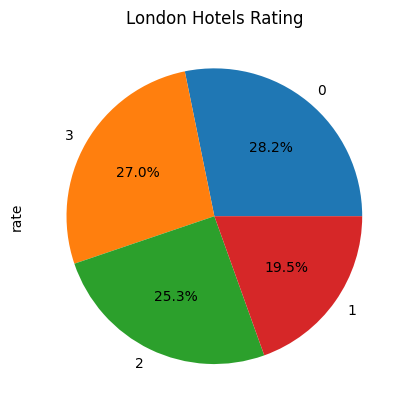

In [54]:
#Check the distribution of rate (after undersampled) given by visitors
print (df_eda['rate'].value_counts())
df_eda['rate'].value_counts().plot(kind='pie',autopct='%1.1f%%', title='London Hotels Rating')

Plot distribusi rating masih cenderung balanced.

### Analyze the characteristics of visitors based on hotels and review

Property Name
The Savoy                                                         5417
Mondrian London at Sea Containers                                 4330
The Rembrandt                                                     3028
Corinthia Hotel London                                            2820
Apex London Wall Hotel                                            2205
The Dorchester                                                    1720
Rhodes Hotel                                                      1554
Hotel Xenia, Autograph Collection                                 1524
Ridgemount Hotel                                                  1365
Mandarin Oriental Hyde Park, London                               1215
Bulgari Hotel, London                                              473
The Wellesley Knightsbridge, a Luxury Collection Hotel, London     354
The Lanesborough                                                   324
London Guest House                                             

<Axes: ylabel='Property Name'>

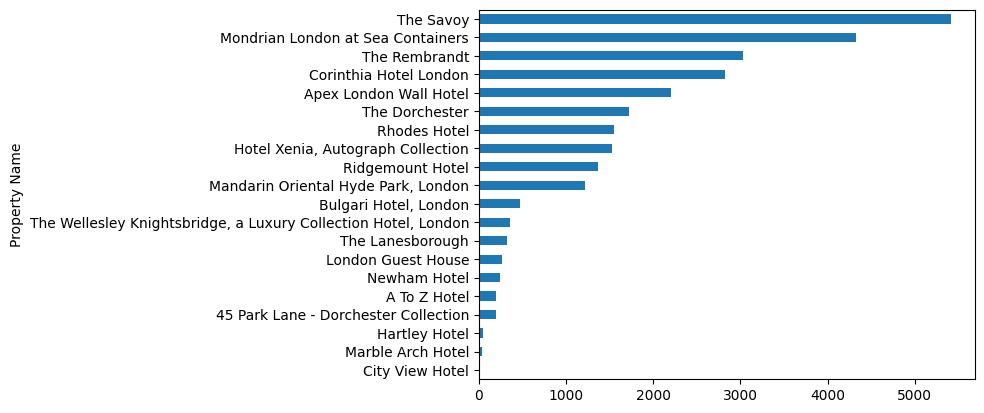

In [36]:
# Check the frequencies of the review for each hotel
print (df.groupby('Property Name')['Property Name'].count().sort_values(ascending=False))
df.groupby('Property Name')['Property Name'].count().sort_values().plot(kind='barh')

Hotel yang memiliki banyak review adalah The Savoy, Mondrian London at Sea Containers, dan The Rembrandt sedangkan hotel dengan paling sedikit review adalah horel City View Hotel, Marble Arch Hotel, dan Hartley Hotel.\
\
Selanjutnya akan dilakukan pengecekan terhadap rating asli yang diberikan oleh pengunjung terhadap 3 hotel terbanyak review dan paling sedikit menerima review.

<Axes: ylabel='Property Name,Review Rating'>

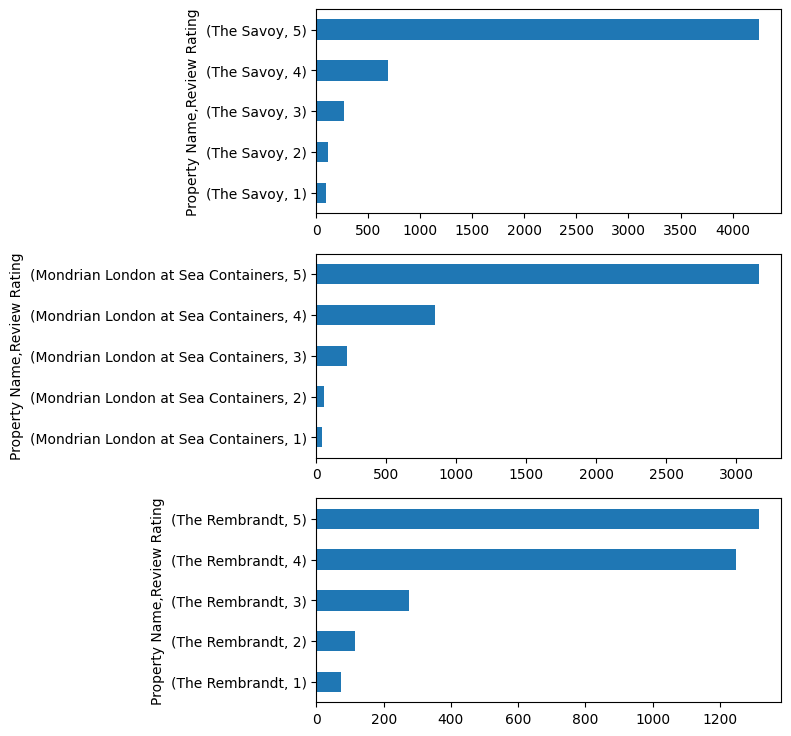

In [37]:
# Plot of the rating given by visitors categorized by the hotel
fig, ax = plt.subplots(nrows=3,figsize=(6,9))
df.loc[df['Property Name']=='The Savoy'].groupby(['Property Name', 
                                                  'Review Rating'])['Review Rating'].count().plot(kind='barh',ax=ax[0])

df.loc[df['Property Name']=='Mondrian London at Sea Containers'].groupby(['Property Name', 
                                                  'Review Rating'])['Review Rating'].count().plot(kind='barh', ax=ax[1])

df.loc[df['Property Name']=='The Rembrandt'].groupby(['Property Name', 
                                                  'Review Rating'])['Review Rating'].count().plot(kind='barh', ax=ax[2])

Ternyata, hotel dengan jumlah review paling banyak cenderung memiliki rating yang tinggi (bagus), yang artinya `pengunjung biasanya memberikan rating paling sering jika mendapatkan pelayanan yang memuaskan`, dilihat dari mayoritas yang memberikan penilaian berkisar dari 4 hingga 5 bintang review.

<Axes: ylabel='Property Name,Review Rating'>

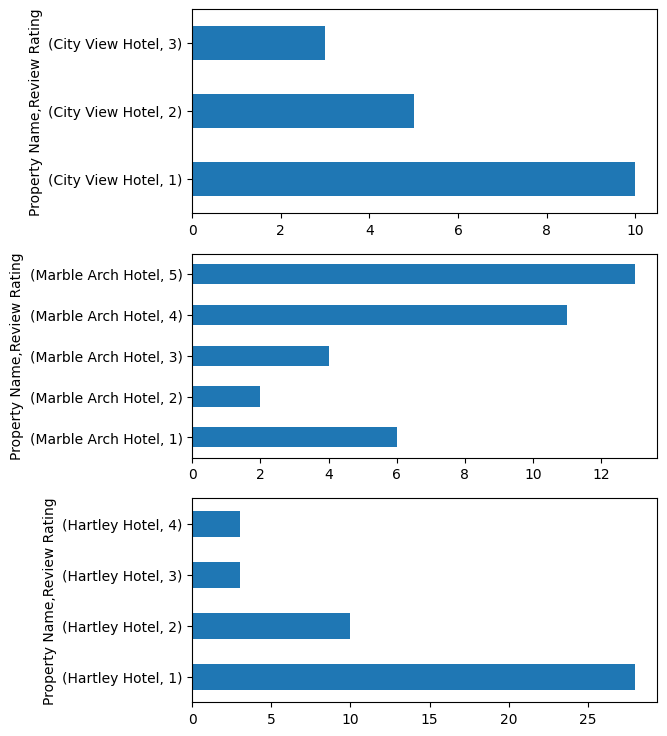

In [38]:
# Plot of the rating given by visitors categorized by the hotel
fig, ax = plt.subplots(nrows=3,figsize=(6,9))
df.loc[df['Property Name']=='City View Hotel'].groupby(['Property Name', 
                                                  'Review Rating'])['Review Rating'].count().plot(kind='barh',ax=ax[0])

df.loc[df['Property Name']=='Marble Arch Hotel'].groupby(['Property Name', 
                                                  'Review Rating'])['Review Rating'].count().plot(kind='barh', ax=ax[1])

df.loc[df['Property Name']=='Hartley Hotel'].groupby(['Property Name', 
                                                  'Review Rating'])['Review Rating'].count().plot(kind='barh', ax=ax[2])

Berdasarkan rating yang diberikan oleh pengunjung kepada `hotel yang jarang mendapatkan review`, terdapat `kecenderungan ketidakpuasan` oleh pengunjung, dilihat dari rating yang paling banyak di bintang 1 dan bahkan ada yang tidak mendapatkan rating di atas bintang 3 sama sekali. Kemungkinan `pengunjung lebih banyak yang memilih untuk tidak memberikan review` ketika tidak mendapatkan pelayanan yang memuaskan ketika berkunjung ke hotel. Kebanyakan pengunjung akan memberikan review jika puas dengan pelayanan hotelnya.\
\
Jika kita melihat kepada `Marble Arch Hotel`, dilihat distribusi rating yang diberikan `cukup banyak di bintang 5`, yang artinya, meskipun hotel ini jarang diberikan review oleh pengunjung, pengunjung yang memberikan rating masih sering memberikan bintang 5 kepada hotel ini. Akan dilakukan pengecekan apakah hotel ini tergolong hotel baru atau tidak.

In [51]:
print ("First reviewed on", df.loc[df['Property Name']=='City View Hotel']['Date Of Review'].min().strftime('%d %B %Y'))
print ("Recently reviewed on", df.loc[df['Property Name']=='City View Hotel']['Date Of Review'].max().strftime('%d %B %Y'))

First reviewed on 24 April 2017
Recently reviewed on 28 July 2018


In [52]:
print ("First reviewed on", df.loc[df['Property Name']=='Hartley Hotel']['Date Of Review'].min().strftime('%d %B %Y'))
print ("Recently reviewed on", df.loc[df['Property Name']=='Hartley Hotel']['Date Of Review'].max().strftime('%d %B %Y'))

First reviewed on 18 August 2011
Recently reviewed on 17 August 2018


In [53]:
print ("First reviewed on", df.loc[df['Property Name']=='Marble Arch Hotel']['Date Of Review'].min().strftime('%d %B %Y'))
print ("Recently reviewed on", df.loc[df['Property Name']=='Marble Arch Hotel']['Date Of Review'].max().strftime('%d %B %Y'))

First reviewed on 11 June 2009
Recently reviewed on 24 June 2018


Ternyata, `Marble Arch Hotel` bukanlah hotel baru, jika dibandingkan dengan hotel-hotel lain, diasumsikan bahwa hotel ini sedikit berbeda dari hotel-hotel yang jarang diberikan review (yakni hotel yang sukar dikunjungi karena rating yang buruk), kemungkinan hotel ini tidak cukup terkenal oleh banyak pengunjung hotel.

### Len of Sentences

In [55]:
# Create columns len_sentences from nltk
df_eda['len_sentences'] = df_eda['text'].apply(lambda x : len(nltk.sent_tokenize(x)))
df_eda

,text,rate,len_sentences,len_words
0,Well I am no strange to London's 5star hotels ...,0,17,293
1,was so looking forward to staying here had hig...,0,1,72
2,I had always wanted to stay at The Dorchester....,0,23,416
3,Having tried the Dorchester hotel in LA and Pa...,0,5,164
4,Wow what a disappointment! Booked this hotel t...,0,20,397
...,...,...,...,...
4307,Outstanding property. The staff are very helpf...,3,4,43
4308,Overnight stay for shopping and spa. Absolutel...,3,4,42
4309,We stayed at the Xenia in Kensington for the f...,3,8,256
4310,"I had taken a brief to London, while assisting...",3,57,907


In [56]:
print ("Max number of sentences for each review :", df_eda['len_sentences'].max())
print ("Average number of sentences for each review : {:.1f}".format(df_eda['len_sentences'].mean()))

Max number of sentences for each review : 234
Average number of sentences for each review : 9.3


Jika dilihat dari jumlah kalimat maksimal yang diberikan pengunjung, ada pengunjung yang memberikan review paling panjang, 234 kalimat, sedangkan biasanya pengunjung hanya memberikan review rata-rata sekitar 9 kalimat. Akan dicek bagaimana pengaruh rating terhadap jumlah kalimat yang diberikan oleh pengunjung.

In [57]:
for i in range (0,4):
    print ("Max number of sentences for each review in rate ",i," :", df_eda.loc[df_eda['rate']==i]['len_sentences'].max())
    print ("Average number of sentences for each review in rate ",i," : {:.1f}".format(df_eda.loc[df_eda['rate']==i]['len_sentences'].mean()))
    print ('\n')

Max number of sentences for each review in rate  0  : 234
Average number of sentences for each review in rate  0  : 10.9


Max number of sentences for each review in rate  1  : 69
Average number of sentences for each review in rate  1  : 11.0


Max number of sentences for each review in rate  2  : 95
Average number of sentences for each review in rate  2  : 8.0


Max number of sentences for each review in rate  3  : 84
Average number of sentences for each review in rate  3  : 7.6




Semakin kecil rating yang diberikan oleh pengunjung, semakin banyak rata-rata kalimat review yang diberikan ke hotel tersebut. Diduga karena pengunjung jarang memberikan review kepada hotel yang tidak memberikan pelayanan yang memuaskan, maka biasanya jika ada pengunjung yg tidak puas namun memberikan review, mereka akan memberikan review sebanyak-banyaknya (max sentences) dari review yang diberikan lebih banyak daripada pengunjung yang cukup puas atau sudah puas dengan pelayanan hotel. Ini disebabkan karena biasanya pengunjung akan lebih menyadari hal yang membuat mereka tidak puas dibandingkan hal yang membuat mereka puas, sehingga komentar terhadap komplain biasanya lebih banyak.

### Len of Words

In [58]:
# Create columns len_words from nltk
df_eda['len_words']=df_eda['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df_eda

,text,rate,len_sentences,len_words
0,Well I am no strange to London's 5star hotels ...,0,17,293
1,was so looking forward to staying here had hig...,0,1,72
2,I had always wanted to stay at The Dorchester....,0,23,416
3,Having tried the Dorchester hotel in LA and Pa...,0,5,164
4,Wow what a disappointment! Booked this hotel t...,0,20,397
...,...,...,...,...
4307,Outstanding property. The staff are very helpf...,3,4,43
4308,Overnight stay for shopping and spa. Absolutel...,3,4,42
4309,We stayed at the Xenia in Kensington for the f...,3,8,256
4310,"I had taken a brief to London, while assisting...",3,57,907


In [59]:
print ("Max number of words for each review :", df_eda['len_words'].max())
print ("Average number of words for each review : {:.1f}".format(df_eda['len_words'].mean()))

Max number of words for each review : 6424
Average number of words for each review : 183.2


Jika dilihat dari jumlah kata maksimal yang diberikan pengunjung, ada pengunjung yang memberikan review paling banyak, 6424 kata, sedangkan biasanya pengunjung hanya memberikan review rata-rata sekitar 183 kata. Akan dicek bagaimana pengaruh rating terhadap jumlah kata yang diberikan oleh pengunjung.

In [60]:
for i in range (0,4):
    print ("Max number of words for each review in rate ",i," :", df_eda.loc[df_eda['rate']==i]['len_words'].max())
    print ("Average number of words for each review in rate ",i," : {:.1f}".format(df_eda.loc[df_eda['rate']==i]['len_words'].mean()))
    print ('\n')

Max number of words for each review in rate  0  : 6424
Average number of words for each review in rate  0  : 228.8


Max number of words for each review in rate  1  : 1473
Average number of words for each review in rate  1  : 220.8


Max number of words for each review in rate  2  : 1634
Average number of words for each review in rate  2  : 150.4


Max number of words for each review in rate  3  : 2166
Average number of words for each review in rate  3  : 139.2




Masih mirip dengan analisis sebelumnya mengenai jumlah kalimat yang diberikan oleh review pengunjung, semakin kecil rating yang diberikan oleh pengunjung, semakin banyak rata-rata kata review yang diberikan ke hotel tersebut. Hal ini disebabkan oleh banyaknya komplain yang dijelaskan kepada review hotel tersebut.

### Sentiment for each text

Melakukan pengecekan sentimen masing-masing rating.

In [61]:
# Check the tag and sentiment for all tokens in first sentences of our data
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
doc = nlp(data_eng.text[0])
doc._.blob.polarity   
for token in doc:
    print(token.text, token.pos_)

I PRON
had VERB
a DET
pleasure NOUN
of ADP
staying VERB
in ADP
this DET
hotel NOUN
for ADP
7 NUM
nights NOUN
recently ADV
. PUNCT
This DET
hotel NOUN
was AUX
perfect ADJ
in ADP
every DET
way NOUN
. PUNCT
Communication NOUN
with ADP
the DET
hotel NOUN
before ADP
staying VERB
was AUX
prompt ADJ
, PUNCT
and CCONJ
very ADV
efficient ADJ
. PUNCT
Checking VERB
in ADP
was AUX
a DET
breeze NOUN
. PUNCT
You PRON
go VERB
through ADP
the DET
spectacular ADJ
lobby NOUN
with ADP
modern ADJ
glass NOUN
chandeliers NOUN
and CCONJ
take VERB
the DET
elevator NOUN
to ADP
your PRON
room NOUN
. PUNCT
My PRON
room NOUN
, PUNCT
they PRON
gave VERB
me PRON
an DET
upgrade NOUN
to ADP
junior ADJ
suite NOUN
, PUNCT
was AUX
spectacular ADJ
. PUNCT
We PRON
had VERB
a DET
walk VERB
- PUNCT
in ADP
closet NOUN
of ADP
the DET
size NOUN
where SCONJ
you PRON
could AUX
have AUX
put VERB
a DET
small ADJ
bed NOUN
in ADP
there ADV
; PUNCT
it PRON
served VERB
us PRON
nicely ADV
for ADP
the DET
seven NUM
day NOUN
stay NOUN
. 

In [62]:
# create column sentiment with spacy
df_eda['sentiment']=df_eda.text.apply(lambda x : 'positive' if (nlp(x)._.blob.polarity>0) else 'negative')
df_eda

,text,rate,len_sentences,len_words,sentiment
0,Well I am no strange to London's 5star hotels ...,0,17,293,positive
1,was so looking forward to staying here had hig...,0,1,72,positive
2,I had always wanted to stay at The Dorchester....,0,23,416,positive
3,Having tried the Dorchester hotel in LA and Pa...,0,5,164,positive
4,Wow what a disappointment! Booked this hotel t...,0,20,397,negative
...,...,...,...,...,...
4307,Outstanding property. The staff are very helpf...,3,4,43,positive
4308,Overnight stay for shopping and spa. Absolutel...,3,4,42,positive
4309,We stayed at the Xenia in Kensington for the f...,3,8,256,positive
4310,"I had taken a brief to London, while assisting...",3,57,907,positive


<Axes: ylabel='rate,sentiment'>

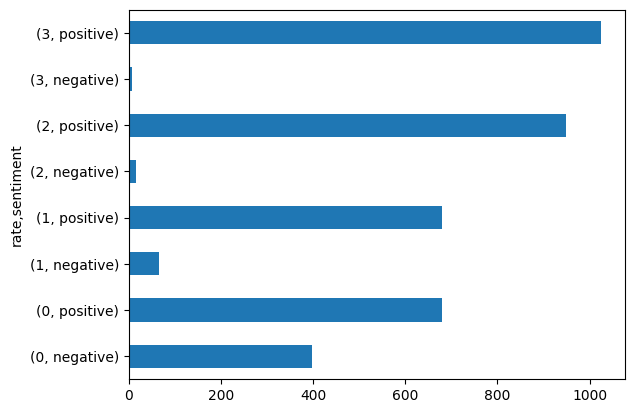

In [63]:
# check the sentiment tendencies for each rate
df_eda.groupby(['rate', 'sentiment'])['rate'].count().plot(kind='barh')

Hotel dengan rate yang tinggi cenderung memiliki sentiment review yang positif, sedangkan hotel dengan rate yang rendah, yakni rate 0, memiliki sentiment review yang negatif jika dibandingkan dari hotel dengan rate lain.

### Plot Word

#### Word Cloud All Text

In [64]:
# concate all text
all_text = ' '.join(df_eda.text.values)
type(all_text)

str

In [65]:
# create the tag for each token
doc1 = nlp(all_text[:1000000])
text_token=[]
tag_token=[]

for token in doc1:
    text_token.append(token.text)
    tag_token.append(token.pos_)
    
    
doc2 = nlp(all_text[1000000:2000000])
for token in doc2:
    text_token.append(token.text)
    tag_token.append(token.pos_)
    

doc3 = nlp(all_text[2000000:3000000])
for token in doc3:
    text_token.append(token.text)
    tag_token.append(token.pos_)
    
doc4 = nlp(all_text[3000000:])
for token in doc4:
    text_token.append(token.text)
    tag_token.append(token.pos_)

    
# create a dataframe with tag
df_tag=pd.DataFrame({'text': text_token, 'tag': tag_token})
df_tag

,text,tag
0,Well,INTJ
1,I,PRON
2,am,AUX
3,no,ADV
4,strange,ADJ
...,...,...
705424,more,ADJ
705425,and,CCONJ
705426,more,ADV
705427,popular,ADJ


Select hanya yang tag=='ADJ' untuk mengambil kategori kata sifat dari semua token.

In [66]:
# Create dataframe with tag==ADJ only
df_adj=df_tag.loc[df_tag['tag']=='ADJ']
df_adj

,text,tag
4,strange,ADJ
13,new,ADJ
19,eager,ADJ
60,4th,ADJ
109,light,ADJ
...,...,...
705389,generous,ADJ
705396,delicious,ADJ
705405,lovely,ADJ
705424,more,ADJ


In [67]:
# join all new adjective to be plotted on word cloud
all_adj= ' '.join(df_adj.text.values)

(-0.5, 399.5, 199.5, -0.5)

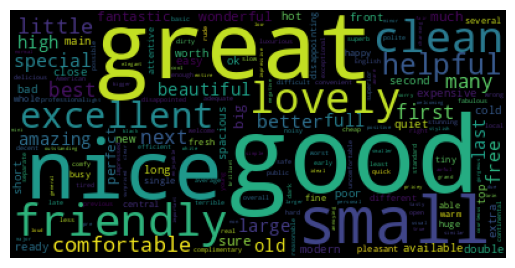

In [68]:
# Plot all cord cloud for all review
cloud_all = WordCloud(max_words=5000, background_color="black", 
                      relative_scaling = 0.5,collocations=False).generate(all_adj)

plt.imshow(cloud_all)
plt.axis("off")

Kebanyakan pengunjung memberi review yang bersifat positif, dilihat dari kata `good, great, nice, and lovely` yang mendominasi plot wordcloud, namun ada beberapa pengunjung yang nampak belum puas sehingga kebanyakan pengunjung yang komplain berfokus pada ukuran kamar yang kecil, dilihat dari kata `small` yang cukup besar tampil dalam wordcloud plot.

#### Word Cloud Based on Rating

In [69]:
# join all text based rating
all_text_r0 = ' '.join(df_eda.loc[df_eda['rate']==0].text.values)
all_text_r1 = ' '.join(df_eda.loc[df_eda['rate']==1].text.values)
all_text_r2 = ' '.join(df_eda.loc[df_eda['rate']==2].text.values)
all_text_r3 = ' '.join(df_eda.loc[df_eda['rate']==3].text.values)

In [70]:
# create dataframe rate 0 with only adective words
text_tokenr0=[]
tag_tokenr0=[]

for token in nlp(all_text_r0[:1000000]):
    text_tokenr0.append(token.text)
    tag_tokenr0.append(token.pos_)
    
for token in nlp(all_text_r0[1000000:]):
    text_tokenr0.append(token.text)
    tag_tokenr0.append(token.pos_)
    
df_tag_r0=pd.DataFrame({'text': text_tokenr0, 'tag': tag_tokenr0})
df_adj_r0=df_tag_r0.loc[df_tag_r0['tag']=='ADJ']

In [71]:
# create dataframe rate 1 with only adective words
text_tokenr1=[]
tag_tokenr1=[]

for token in nlp(all_text_r1[:1000000]):
    text_tokenr1.append(token.text)
    tag_tokenr1.append(token.pos_)
    
for token in nlp(all_text_r1[1000000:]):
    text_tokenr1.append(token.text)
    tag_tokenr1.append(token.pos_)
    
df_tag_r1=pd.DataFrame({'text': text_tokenr1, 'tag': tag_tokenr1})
df_adj_r1=df_tag_r1.loc[df_tag_r1['tag']=='ADJ']

In [72]:
# create dataframe rate 2 with only adective words
text_tokenr2=[]
tag_tokenr2=[]

for token in nlp(all_text_r2[:1000000]):
    text_tokenr2.append(token.text)
    tag_tokenr2.append(token.pos_)
    
for token in nlp(all_text_r2[1000000:]):
    text_tokenr2.append(token.text)
    tag_tokenr2.append(token.pos_)
    
df_tag_r2=pd.DataFrame({'text': text_tokenr2, 'tag': tag_tokenr2})
df_adj_r2=df_tag_r2.loc[df_tag_r2['tag']=='ADJ']

In [73]:
# create dataframe rate 3 with only adective words
text_tokenr3=[]
tag_tokenr3=[]

for token in nlp(all_text_r3[:1000000]):
    text_tokenr3.append(token.text)
    tag_tokenr3.append(token.pos_)
    
for token in nlp(all_text_r3[1000000:]):
    text_tokenr3.append(token.text)
    tag_tokenr3.append(token.pos_)
    
df_tag_r3=pd.DataFrame({'text': text_tokenr3, 'tag': tag_tokenr3})
df_adj_r3=df_tag_r3.loc[df_tag_r3['tag']=='ADJ']

In [74]:
# join all adjective words based on rating
all_adj_r0= ' '.join(df_adj_r0.text.values)
all_adj_r1= ' '.join(df_adj_r1.text.values)
all_adj_r2= ' '.join(df_adj_r2.text.values)
all_adj_r3= ' '.join(df_adj_r3.text.values)

(-0.5, 399.5, 199.5, -0.5)

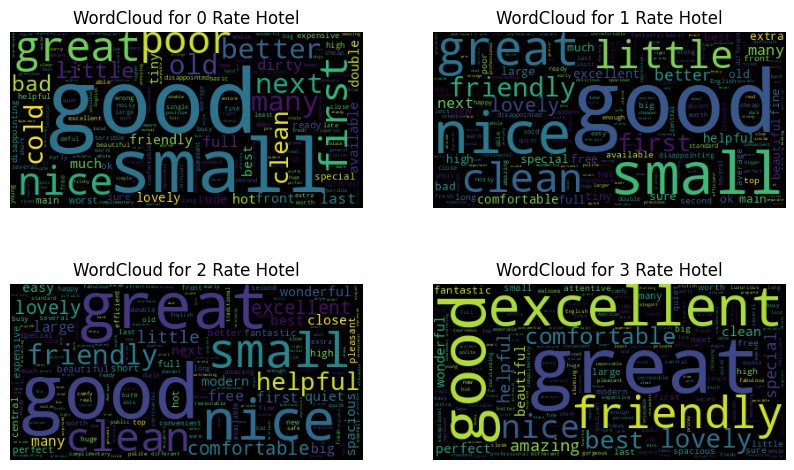

In [75]:
# Define the wordcloud based on rating
cloud_all0 = WordCloud(max_words=5000, background_color="black", 
                      relative_scaling = 0.5,collocations=False).generate(all_adj_r0)

cloud_all1 = WordCloud(max_words=5000, background_color="black", 
                      relative_scaling = 0.5,collocations=False).generate(all_adj_r1)

cloud_all2 = WordCloud(max_words=5000, background_color="black", 
                      relative_scaling = 0.5,collocations=False).generate(all_adj_r2)
cloud_all3 = WordCloud(max_words=5000, background_color="black", 
                      relative_scaling = 0.5,collocations=False).generate(all_adj_r3)


# Plot wordcloud absed on rating
plt.figure(figsize=[10,6])
ax0 = plt.subplot(221)
ax0.imshow(cloud_all0)
ax0.set_title("WordCloud for 0 Rate Hotel")
ax0.axis("off")

ax1 = plt.subplot(222)
ax1.imshow(cloud_all1)
ax1.set_title("WordCloud for 1 Rate Hotel")
ax1.axis("off")

ax2 = plt.subplot(223)
ax2.imshow(cloud_all2)
ax2.set_title("WordCloud for 2 Rate Hotel")
ax2.axis("off")

ax3 = plt.subplot(224)
ax3.imshow(cloud_all3)
ax3.set_title("WordCloud for 3 Rate Hotel")
ax3.axis("off")



1.   Rate 0 kebanyakan memberikan komplain berupa kamar yang kecil, tua, dingin, dan kotor. Namun ada banyak juga pengunjung yang memberikan masukan seperti kata `good`
2.   Rate 1 dan 2 kebanyakan memberikan pujian seperti good nice and clean, namun masih ada sedikit komplain seperti tempatnya yg kecil
3. Rate 3 hanya berisikan pujian yang berarti pengunjung yang memberikan rate ini biasanya sudah sangat puas sehingga tidak memberikan komplain



### Sample Review For Each Rate

In [224]:
# Create sample for each rate
sample_r0=df_eda[df_eda['rate']==0].sample(n=3)
sample_r1=df_eda[df_eda['rate']==1].sample(n=3)
sample_r2=df_eda[df_eda['rate']==2].sample(n=3)
sample_r3=df_eda[df_eda['rate']==3].sample(n=3)

In [225]:
# Create function to print the sample
def print_sample(sample):
    rate=sample['rate'].unique()[0]
    print ("## Review Sample of "+str(rate)+" Rate Hotel ##")
    print ('='*125)
    for i in range (len(sample)):
        print (sample.iloc[i,0])
        print ('\n')
        
    print ('='*125)

In [226]:
# Print sample review
print_sample(sample_r0)
print_sample(sample_r1)
print_sample(sample_r2)
print_sample(sample_r3)

## Review Sample of 0 Rate Hotel ##
Was very disappointed after receiving poor service at Northall Bar last weekend, we sat at a table only to be moved after 10 minutes waiting for a staff members to come to us. Instead of asking about our order, we were told that the table was reserved despite no sign on it (other tables had reserved signs). | There were what appear to be two wedding parties in the bar and we were clearly to casual looking for the team there... | The hotel charge £9.50 for a very small glass of wine, possibly the smallest I have ever been served, coffee was good but at £5.50 (all prices before service charge by the way!), it would need to be.... | I also had to ask twice for the bill, left after what felt like a very bad experience, I will not be in a rush to return!


As an avid traveller who has traveled to 11 countries and stayed in a variety of accommodation types from hostels to 5* hotels, I can honestly say I have never met such a hostile and bad-mannered owner 

Sesuai ekspektasi dari wordcloud dan sentiment yang telah kita analisis sebelumnya, sample dengan rate 0 biasanya memberikan komplain, sedangkan semakin tinggi ratenya semakin sedikit komplain yang diberikan. Ada beberapa kata yang typo dan tidak bisa dimengerti oleh bahasa manusia apalagi bahasa komputer, seperti contoh : `B&amp;`, sehingga kata-kata ini akan dihandle saat preprocessing.

## Text Preprocessing

Berdasarkan hasil EDA di atas, ditemukan beberapa tanda baca, typo, kata-kata stopwords seperti `was`, `have`, `had`, dsb. Kata-kata ini kemudian akan dihandle saat pre processing kali ini.

### Lowercase

Mengubah text menjadi lowercase untuk mengurangi adanya perbedaan antara yang menggunakan huruf kapital semua seperi (Tourism) pada sample dan tourism, menurut kami ini tidak akan ada bedanya sehingga semua text akan dijadikan lowercase.

In [80]:
# Change to lowercase

teks = df_eda.text[0]
teks_lower = teks.lower()
print (teks_lower)
print ('Rate :',df_eda.rate[0])

well i am no strange to london's 5star hotels and when a new one comes along i am eager to try. so i heard about the corinthia via some friends who work in the industry and said their bar was really something. until the incident i had stay there a total of 3 times but on the 4th time in june i was on my second of 4 nights and was about get some cash from my room as i was going to exchange money for some dollars as i was flying to the us pretty soon. when i came to my money it felt light. when i counted it, it was almost £1000 down. obviously shocked i contacted reception. they started an investigation! | well a couple of days later i had to checkout and the matter was not resolved. i was made to pay my bill in full. | upon my return to london i met up with a manager at the hotel jean louis. he said the matter was still under investigation and he gave me his card to get in touch. nothing was ever resolved. | this hotel does not only boast to be one of the best hotels in london but one o

### Remove punctuation

#### Check Punctuation

In [81]:
# check punctuation
punctuation = re.findall(r'[^\w\s]', all_text)
print (list(set(punctuation)))

['-', '\x94', '\x97', '´', '·', '^', '\x96', '\x93', '~', ',', '[', "'", '\x80', '/', '!', '.', '$', '`', '(', ':', '%', '+', ')', '"', '\x92', '{', '=', '\x91', '?', '}', ']', '&', '>', '<', '*', '|', '#', '£', '\x95', '@', '\\', '°', ';']


Terdapat banyak punctuation (tanda baca) yang tidak memiliki arti dalam suatu kalimat, sehingga ini akan dibuang.

In [82]:
# remove punctuation

teks_punc = teks_lower.translate(str.maketrans('', '', string.punctuation))
teks_punc

'well i am no strange to londons 5star hotels and when a new one comes along i am eager to try so i heard about the corinthia via some friends who work in the industry and said their bar was really something until the incident i had stay there a total of 3 times but on the 4th time in june i was on my second of 4 nights and was about get some cash from my room as i was going to exchange money for some dollars as i was flying to the us pretty soon when i came to my money it felt light when i counted it it was almost £1000 down obviously shocked i contacted reception they started an investigation  well a couple of days later i had to checkout and the matter was not resolved i was made to pay my bill in full  upon my return to london i met up with a manager at the hotel jean louis he said the matter was still under investigation and he gave me his card to get in touch nothing was ever resolved  this hotel does not only boast to be one of the best hotels in london but one of the best in th

### Remove hashtag

Pada sample yang didapat, tidak dilihat adanya hashtag yang muncul, namun agar mengurangi adanya simbolik yang tidak perlu, kami juga melakukan remove hashtag.

In [84]:
# remove Hashtag
teks_punc = re.sub("#[A-Za-z0-9_]+", " ", teks_punc)

### Remove new line

Agar kalimat yang dibaca oleh model tidak memiliki double new line, kami juga mencoba menghilankan duplikasi new line.

In [85]:
# remove \n
teks_punc = re.sub(r"\\n", " ", teks_punc)

### Remove whitespace

Sering kali adanya leading maupun trailing whitespace pada text review, yang mana tidak memiliki makna tertentu, sehingga akan diatasi dengan menghapus whitespace tersebut.

In [86]:
# remove Whitespace
teks_punc = teks_punc.strip()

### Remove Emoji

Beberapa pengunjung terutama yang menggunakan mobile phone untuk melakukan review, seringkali memberikan emoji pada review yang diberikan, yang mana ini tidak akan dibaca komputer sebagai kata tertentu, sehingga akan dilakukan penghapusan terhadap simbol-simbol tersebut

In [87]:
# Remove Emoji, Mathematic symbols (ex : μ), etc
teks_punc = re.sub("[^A-Za-z\s']", " ", teks_punc)

### Remove stopwords

Menghapus adanya kata-kata stopwords agar eda dan pemodelan hanya berfokus pada kata-kata yang memiliki makna yang dapat dianalisis saja.

In [88]:
# List Stopwords
stpwds_en = list(set(stopwords.words('english')))

# tokenize words
tokens = word_tokenize(teks_punc)
teks_stopwords = [word for word in tokens if word not in stpwds_en]

### Stemming the text

Mengembalikan kata-kata dalam suatu kalimat menjadi kata baku atau kata hasil stemming agar tidak memperbanyak jumlah vocab yang akan dimodelkan.

In [89]:
# Define the stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()

In [90]:
# Stemming the sentence
stemmed_words = []

for word in teks_stopwords:
    stemmed_words.append(stemmer.stem(word))
    
stemmed_sentence = " ".join(stemmed_words)
stemmed_sentence

'well strang london star hotel new one come along eager tri heard corinthia via friend work industri said bar realli someth incid stay total time th time june second night get cash room go exchang money dollar fli us pretti soon came money felt light count almost obvious shock contact recept start investig well coupl day later checkout matter resolv made pay bill full upon return london met manag hotel jean loui said matter still investig gave card get touch noth ever resolv hotel boast one best hotel london one best world pay premium reason expect premium servic hotel epic fail dent confid hotel industri didnt even get formal apolog love hotel would say stay risk night risk'

### Preprocess All Document

Sekarang akan kami lakukan pre process terhadap semua dokumen mengikuti tahapan yang sebelumnya dilakukan untuk 1 data.

In [92]:
# Create function to clean the text

def clean_stemm_proses(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    text

    # Remove Hashtag
    text = re.sub("#[A-Za-z0-9_]+", " ", text)

    # Remove \n
    text = re.sub(r"\\n", " ",text)

    # Remove Whitespace
    text = text.strip()

    # Remove emoji
    text = re.sub("[^A-Za-z\s']", " ", text)

    # Tokenization
    tokens = word_tokenize(text)

    # remove Stopwords
    stpwds_en = list(set(stopwords.words('english')))
    text = [word for word in tokens if word not in stpwds_en]
    
    # Stemming
    stemmed_words = []
    for word in text:
        stemmed_words.append(stemmer.stem(word))

    stemmed_sentence = " ".join(stemmed_words)

    return stemmed_sentence

In [93]:
# Clean the text using the clean_stemm_proses function

df_eda['text_clean_stemm'] = df_eda['text'].apply(lambda x: clean_stemm_proses(x))
df_eda

,text,rate,len_sentences,len_words,sentiment,text_clean_stemm
0,Well I am no strange to London's 5star hotels ...,0,17,293,positive,well strang london star hotel new one come alo...
1,was so looking forward to staying here had hig...,0,1,72,positive,look forward stay high expect let connect room...
2,I had always wanted to stay at The Dorchester....,0,23,416,positive,alway want stay dorchest seem grand quintessen...
3,Having tried the Dorchester hotel in LA and Pa...,0,5,164,positive,tri dorchest hotel la pari satisfi decid give ...
4,Wow what a disappointment! Booked this hotel t...,0,20,397,negative,wow disappoint book hotel amex fhr never retur...
...,...,...,...,...,...,...
4307,Outstanding property. The staff are very helpf...,3,4,43,positive,outstand properti staff help profession room s...
4308,Overnight stay for shopping and spa. Absolutel...,3,4,42,positive,overnight stay shop spa absolut fantast hotel ...
4309,We stayed at the Xenia in Kensington for the f...,3,8,256,positive,stay xenia kensington first time night coupl w...
4310,"I had taken a brief to London, while assisting...",3,57,907,positive,taken brief london assist execut friend known ...


Data yang sudah di-clean menggunakan function clean_stemm_proses kemudian akan dipakai untuk pemodelan dan EDA setelah preprosessed.

## Exploratory Data Analysis (After Preprocessed)

Menganalisis kembali data yang sudah dilakukan pre process.

### Sentiment of the text

In [94]:
# create new df_eda
df_eda2=df_eda.copy()

In [95]:
# create new sentiment of the text for each data
df_eda2['sentiment']=df_eda2.text.apply(lambda x : 'positive' if (nlp(x)._.blob.polarity>0) else 'negative')
df_eda2

,text,rate,len_sentences,len_words,sentiment,text_clean_stemm
0,Well I am no strange to London's 5star hotels ...,0,17,293,positive,well strang london star hotel new one come alo...
1,was so looking forward to staying here had hig...,0,1,72,positive,look forward stay high expect let connect room...
2,I had always wanted to stay at The Dorchester....,0,23,416,positive,alway want stay dorchest seem grand quintessen...
3,Having tried the Dorchester hotel in LA and Pa...,0,5,164,positive,tri dorchest hotel la pari satisfi decid give ...
4,Wow what a disappointment! Booked this hotel t...,0,20,397,negative,wow disappoint book hotel amex fhr never retur...
...,...,...,...,...,...,...
4307,Outstanding property. The staff are very helpf...,3,4,43,positive,outstand properti staff help profession room s...
4308,Overnight stay for shopping and spa. Absolutel...,3,4,42,positive,overnight stay shop spa absolut fantast hotel ...
4309,We stayed at the Xenia in Kensington for the f...,3,8,256,positive,stay xenia kensington first time night coupl w...
4310,"I had taken a brief to London, while assisting...",3,57,907,positive,taken brief london assist execut friend known ...


<Axes: ylabel='rate,sentiment'>

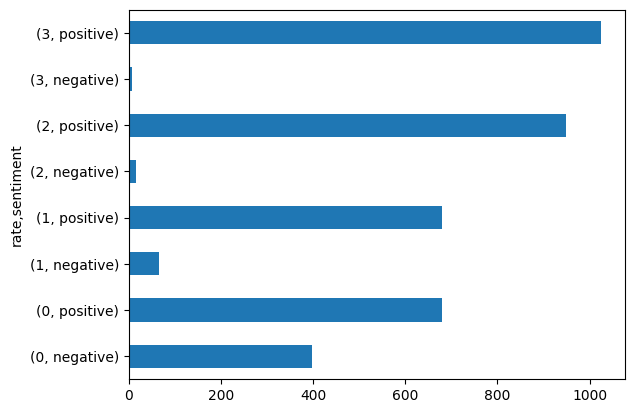

In [96]:
# check sentiment of the data
df_eda2.groupby(['rate', 'sentiment'])['rate'].count().plot(kind='barh')

Tidak ada perbedaan dengan yang sebelum dilakukan preprocessing, sehingga sifat sentiment untuk masing-masing rating masih sama.

### Plot Word Cloud

In [97]:
# join all text for each rate
all_text_r0_2 = ' '.join(df_eda2.loc[df_eda['rate']==0].text_clean_stemm.values)
all_text_r1_2 = ' '.join(df_eda2.loc[df_eda['rate']==1].text_clean_stemm.values)
all_text_r2_2 = ' '.join(df_eda2.loc[df_eda['rate']==2].text_clean_stemm.values)
all_text_r3_2 = ' '.join(df_eda2.loc[df_eda['rate']==3].text_clean_stemm.values)

In [98]:
# create dataframe to select only adj
text_tokenr0_2=[]
tag_tokenr0_2=[]

for token in nlp(all_text_r0_2):
    text_tokenr0_2.append(token.text)
    tag_tokenr0_2.append(token.pos_)
    
df_tag_r0_2=pd.DataFrame({'text': text_tokenr0_2, 'tag': tag_tokenr0_2})
df_adj_r0_2=df_tag_r0_2.loc[df_tag_r0_2['tag']=='ADJ']

In [99]:
# create dataframe to select only adj
text_tokenr1_2=[]
tag_tokenr1_2=[]

for token in nlp(all_text_r1_2):
    text_tokenr1_2.append(token.text)
    tag_tokenr1_2.append(token.pos_)
    
df_tag_r1_2=pd.DataFrame({'text': text_tokenr1_2, 'tag': tag_tokenr1_2})
df_adj_r1_2=df_tag_r1_2.loc[df_tag_r1_2['tag']=='ADJ']

In [100]:
# create dataframe to select only adj
text_tokenr2_2=[]
tag_tokenr2_2=[]

for token in nlp(all_text_r2_2):
    text_tokenr2_2.append(token.text)
    tag_tokenr2_2.append(token.pos_)
    
    
df_tag_r2_2=pd.DataFrame({'text': text_tokenr2_2, 'tag': tag_tokenr2_2})
df_adj_r2_2=df_tag_r2_2.loc[df_tag_r2_2['tag']=='ADJ']

In [101]:
# create dataframe to select only adj
text_tokenr3_2=[]
tag_tokenr3_2=[]

for token in nlp(all_text_r3_2):
    text_tokenr3_2.append(token.text)
    tag_tokenr3_2.append(token.pos_)
    
df_tag_r3_2=pd.DataFrame({'text': text_tokenr3_2, 'tag': tag_tokenr3_2})
df_adj_r3_2=df_tag_r3_2.loc[df_tag_r3_2['tag']=='ADJ']

In [102]:
# join all adj for each rate
all_adj_r0_2= ' '.join(df_adj_r0_2.text.values)
all_adj_r1_2= ' '.join(df_adj_r1_2.text.values)
all_adj_r2_2= ' '.join(df_adj_r2_2.text.values)
all_adj_r3_2= ' '.join(df_adj_r3_2.text.values)

(-0.5, 399.5, 199.5, -0.5)

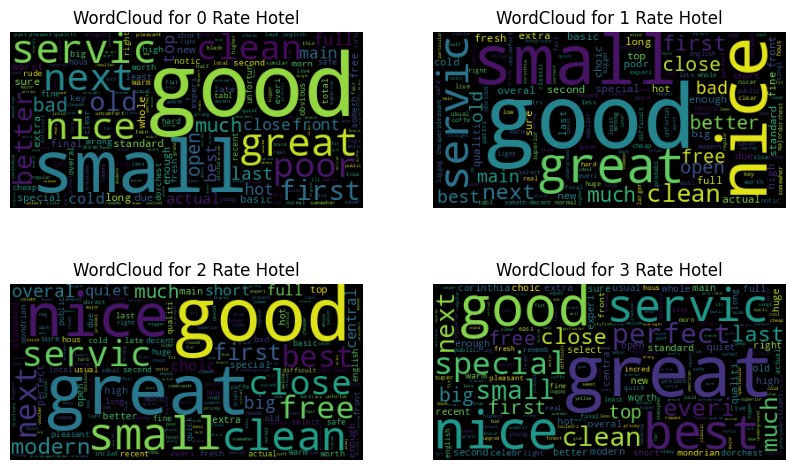

In [103]:
# create wordcloud for each rate
cloud_all0c = WordCloud(max_words=5000, background_color="black", 
                      relative_scaling = 0.5,collocations=False).generate(all_adj_r0_2)

cloud_all1c = WordCloud(max_words=5000, background_color="black", 
                      relative_scaling = 0.5,collocations=False).generate(all_adj_r1_2)

cloud_all2c = WordCloud(max_words=5000, background_color="black", 
                      relative_scaling = 0.5,collocations=False).generate(all_adj_r2_2)
cloud_all3c = WordCloud(max_words=5000, background_color="black", 
                      relative_scaling = 0.5,collocations=False).generate(all_adj_r3_2)

# plot wordcloud
plt.figure(figsize=[10,6])
ax0 = plt.subplot(221)
ax0.imshow(cloud_all0c)
ax0.set_title("WordCloud for 0 Rate Hotel")
ax0.axis("off")

ax1 = plt.subplot(222)
ax1.imshow(cloud_all1c)
ax1.set_title("WordCloud for 1 Rate Hotel")
ax1.axis("off")

ax2 = plt.subplot(223)
ax2.imshow(cloud_all2c)
ax2.set_title("WordCloud for 2 Rate Hotel")
ax2.axis("off")

ax3 = plt.subplot(224)
ax3.imshow(cloud_all3c)
ax3.set_title("WordCloud for 3 Rate Hotel")
ax3.axis("off")

Setelah dilakukan cleaning, nampak terlihat bahwa permasalahan utama di rate 0 dan 1 adalah tempatnya yang kecil, namun di rate 2 masih ada permasalah tempat yang kecil meskipun tidak terlalu banyak. Untuk hotel yang diberikan rate paling tinggi (rate 3), hampir semua karakteristik yang diberikan berupa sentiment positif seperti good, great, perfect, nice, and best.

## Embedding Layer in Deep Learning with Tensorflow

In [104]:
# Splitting Corpus
X_train_val, X_test, y_train_val, y_test = train_test_split(df_eda.text_clean_stemm, 
                                                    df_eda.rate, 
                                                    test_size=0.15, 
                                                    random_state=46, 
                                                    stratify=df_eda.rate)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                    y_train_val, 
                                                    test_size=0.15, 
                                                    random_state=46, 
                                                    stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (2760,)
Val Size :  (488,)
Test Size  :  (574,)


In [105]:
# Get Vocabularies

Vectorize = CountVectorizer(stop_words=stpwds_en)
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<2760x10840 sparse matrix of type '<class 'numpy.int64'>'
	with 177949 stored elements in Compressed Sparse Row format>

Hanya 177949 (5.9e-05%) non zero vocab dari 29918400 (2760x10840) vocabularies.

In [107]:
# Get vocab size and len of token in 1 document

vocab_size = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Vocab size : ", vocab_size)
print("Naximum length of the sentence : ", max_sen_len, "words")

Vocab size :  10840
Naximum length of the sentence :  938 words


Mengubah kata-kata menjadi angka menggunakan text_vectorization

In [109]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=vocab_size,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(X_train)

In [110]:
## Result of Text Vectorization
print('Text Vectorization Result')
print(text_vectorization([df_eda.text_clean_stemm[0]]))
print('Vector size : ', text_vectorization([df_eda.text_clean_stemm[0]]).shape)

Text Vectorization Result
tf.Tensor(
[[  31  944    9   88    3  216   10   99  516 1376   98  763  344  836
   194   65 1909  119   17   29  236 1561    4  455   16  233   16 1267
   265   12   18 1070    2   28 1758  161 1407 1476   13  276  590  174
   161  184  262 1767  392  606  880  601   73  207 1906   31  263   24
   283  648  747 1156   66  108  295  180  337   87    9  710   85    3
  2096 2988  119  747  142 1906  343  217   18  321  159  190 1156    3
  2131   10   81    3    9   10   81  325  108 1157  224   45 1157   11
     3 5156  921 4087 2256    3 1909   50   20   18 1919  526   30    3
     6   71    4 1286   12 1286    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 

In [111]:
# top 20 most frequent

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'room',
 'hotel',
 'stay',
 'staff',
 'would',
 'breakfast',
 'good',
 'london',
 'one',
 'servic',
 'night',
 'us',
 'locat',
 'great',
 'time',
 'bar',
 'get',
 'nice']

Kata-kata yang paling sering muncul adalah room, hotel, dan stay. Kata ini memang akan sering muncul dalam review karena 3 kata tersebut menggambarkan poin utama dari review yang dilakukan pengunjung.

Selanjutnya, akan dilakukan embedding yakni untuk mengubah suatu angka menjadi sekumpulan angka.

In [112]:
# Embedding

embedding = Embedding(input_dim=vocab_size,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

In [113]:
print('Vector size : ', embedding(text_vectorization([df_eda.text_clean_stemm[0]])).shape)

Vector size :  (1, 938, 128)


Ukuran vector setelah dilakukan text_vectorization dan embedding adalah 1 x 938 x 128.

In [114]:
# Load the train and validation using tensorflow pipeline
train_pipe = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(10).shuffle(100).prefetch(tf.data.AUTOTUNE)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(10)

## Model Definition

- Model yang digunakan adalah Model Sequential
- Recurrant neural network yang digunakan adalah Long Short Term Memory (LSTM) dengan jumlah neuron 256 di layer LSTM pertama dan 512 neuron di layer LSTM terakhir
- Digunakan text_vectorization untuk mengubah kata menjadi suatu bilangan agar dapat dimodelkan dengan baik
- Digunakan embedding untuk mengubah suatu angka dari vectorization untuk menjadi sekumpulan angka agar dapat dicari kedekatan maknanya
- Inisialisasi menggunakan HeNormal (mengambil sampel dari distribusi normal terpotong yang berpusat pada 0)
- Regularizer yang digunakan adalah l2 penalty (loss = l2 * reduce_sum(square(x)))
- Fungsi aktivasi yang digunakan adalah softmax (untuk kasus multiclass)
- Optimizer yang digunakan adalah adam (optimisasi yang dapat digunakan sebagai ganti dari prosedur classical stochastic gradient descent untuk memperbarui bobot secara iteratif yang didasarkan pada data training)
- Callback yang digunakan adalah early stop dengan tingkat kesabaran 3 kali dan memonitoring parameter loss

## Model Training

In [116]:
%%time
# Model Training with LSTM
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model = Sequential()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.add(text_vectorization)
model.add(embedding)
model.add(tf.keras.layers.BatchNormalization())
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(512,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(4,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')

model_dnn_hist_1 = model.fit(train_pipe,
                         epochs=50,batch_size=100,
                         callbacks=[callback],
                         validation_data=val_pipe)

Epoch 1/50
276/276 [==============================] - 89s 288ms/step - loss: 1.3863 - accuracy: 0.2739 - val_loss: 1.3779 - val_accuracy: 0.2705
Epoch 2/50
276/276 [==============================] - 38s 137ms/step - loss: 1.3829 - accuracy: 0.2862 - val_loss: 1.3965 - val_accuracy: 0.2828
Epoch 3/50
276/276 [==============================] - 39s 140ms/step - loss: 1.3875 - accuracy: 0.2942 - val_loss: 1.3863 - val_accuracy: 0.2520
Epoch 4/50
276/276 [==============================] - 38s 137ms/step - loss: 1.3820 - accuracy: 0.2877 - val_loss: 1.3831 - val_accuracy: 0.2828
Epoch 5/50
276/276 [==============================] - 38s 137ms/step - loss: 1.3671 - accuracy: 0.3076 - val_loss: 1.3834 - val_accuracy: 0.2705
Epoch 6/50
276/276 [==============================] - 40s 145ms/step - loss: 1.3445 - accuracy: 0.3565 - val_loss: 1.4568 - val_accuracy: 0.2705
Epoch 7/50
276/276 [==============================] - 38s 137ms/step - loss: 1.3281 - accuracy: 0.3656 - val_loss: 1.3792 - val_ac

## Model Evaluation

Pada pemodelan kali ini, kami ingin memprediksikan rating yang diberikan oleh pengunjung hotel sehingga baik False Positive maupun False Negative akan memberikan dampak yang sama terhadap target dengan contoh multiclass, sehingga kami akan menggunakan `metric akurasi`. Akurasi dapat digunakan dalam kasus data yang sudah balanced, sehingga data kami cocok untuk metric kali ini.

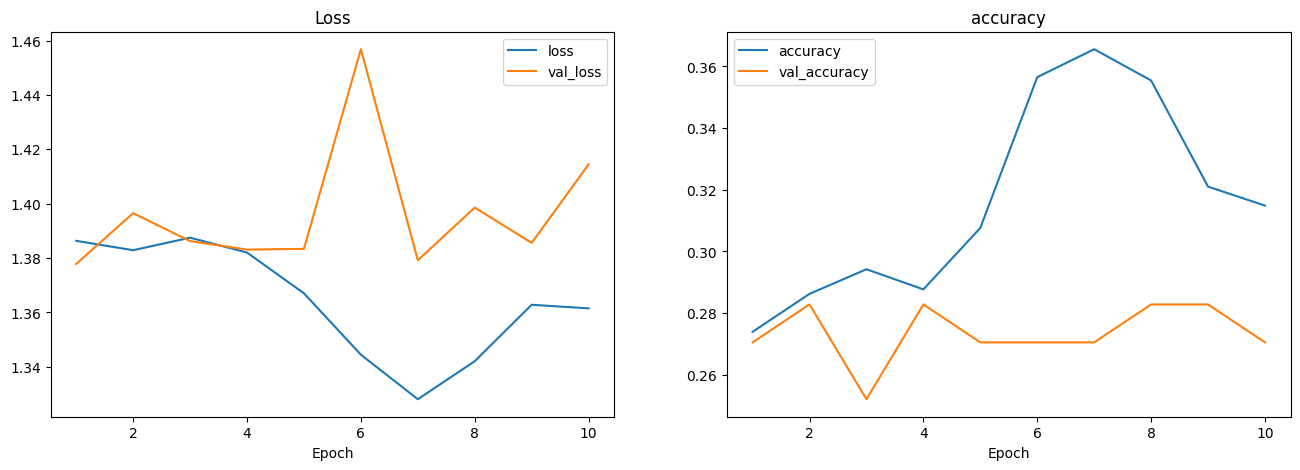

In [118]:
# Performance of the model

metrics = pd.DataFrame(model_dnn_hist_1.history)

# Evaluate the loss and accuracy of the model
epoch=10

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),model_dnn_hist_1.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),model_dnn_hist_1.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),model_dnn_hist_1.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),model_dnn_hist_1.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

- Akurasi dari model memiliki nilai yang sangat kecil, yakni 0.2-0.3, nilai loss yang bernilai antara nilai 1 membuat prediksi memiliki gap setidaknya error sebesar -1 atau +1 dari yang seharusnya
- Model masih belum dapat dipakai, perlu dilakukan improvisasi

In [119]:
# Model Evaluation of test-set
y_pred = model.predict(X_test)
y_pred

18/18 [==============================] - 2s 75ms/step


array([[0.186201  , 0.16409156, 0.30762815, 0.34207928],
       [0.18620102, 0.16409157, 0.30762815, 0.34207928],
       [0.186201  , 0.16409156, 0.30762815, 0.34207928],
       ...,
       [0.18620102, 0.16409157, 0.30762815, 0.34207928],
       [0.18620108, 0.16409162, 0.3076281 , 0.3420792 ],
       [0.186201  , 0.16409156, 0.30762815, 0.34207928]], dtype=float32)

In [121]:
# Get the final target prediction
y_pred_new=[]

for i in range (len(y_pred)):
  y_pred_new.append(np.array(y_pred[i]).argmax())

y_pred_new=np.array(y_pred_new)

In [124]:
# Performance of the model
print (classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00       145
           3       0.27      1.00      0.43       155

    accuracy                           0.27       574
   macro avg       0.07      0.25      0.11       574
weighted avg       0.07      0.27      0.11       574



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Nilai akurasi sangat kecil, di bawah 30% sehingga dapat diasumsikan bahwa model belum belajar dengan baik saat train, validasi, maupun test
- Pada model base kali ini, model kami hanya sedikit lebih baik saat memprediksi target rating 3, meskipun nilainya kecil (berdasarkan presisi, recall, dan f1-score), sedangkan untuk kelas lainnya, model ini tidak dapat memprediksikan data tersebut sama sekali, dilihat dari performance score model yang 0.

\
__Kesimpulan__
- Model kami belum bisa bekerja dengan baik saat training maupun test, diduga karena data terlalu sulit atau penggunaan layer yang belum cocok dengan data yang kami gunakan, sehingga akan dilakukan penyesuaian agar dapat menghasilkan performansi model yang lebih baik

## Model Improvement

- Pada improvement kali ini, digunakan bidirectional wrapper, yang dalam beberapa kasus dapat meningkatkan performa LSTM
- Penambahan normalisasi setiap penambahan layer LSTM akan membuat model lebih ringan dan lebih cepat dilatih
- Penambahan layer dropout juga akan mempengaruhi peningkatan model yang overfitting
- Optimizer yang digunakan pada improvement kali ini adalah RMSprop yang pada beberapa kasus dapat meningkatkan performa model dibandingkan menggunakan optimizer Adam
- Dilakukan juga pembobotan terhadap initializer dan regularizer pada kernel dan recurrent karena model kali ini menggunakan recurrent neural network
- Callback yang digunakan adalah early stop dengan tingkat kesabaran 3 kali dan memonitoring parameter loss

In [210]:
%%time
# Model Training dengan menggunakan Dense Layer
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model2 = Sequential([
    text_vectorization,
    embedding,
    Bidirectional(LSTM(32, return_sequences=True, kernel_initializer='HeNormal', recurrent_initializer='HeNormal',kernel_regularizer='l2', recurrent_regularizer='l2')),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.01),

    Bidirectional(LSTM(64, return_sequences=True,kernel_regularizer='l2')),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.01),

    Bidirectional(LSTM(128,kernel_regularizer='l2')),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.01),

    Dense(4,activation='softmax')

])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model2.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.RMSprop(),metrics='accuracy')

model_dnn_hist_2 = model2.fit(train_pipe,
                         epochs=50,
                         callbacks=[callback],
                         validation_data=val_pipe)

Epoch 1/50
276/276 [==============================] - 54s 151ms/step - loss: 10.9170 - accuracy: 0.7453 - val_loss: 7.4065 - val_accuracy: 0.4180
Epoch 2/50
276/276 [==============================] - 40s 145ms/step - loss: 4.1821 - accuracy: 0.8931 - val_loss: 7.6648 - val_accuracy: 0.4816
Epoch 3/50
276/276 [==============================] - 40s 146ms/step - loss: 2.1122 - accuracy: 0.9254 - val_loss: 9.4392 - val_accuracy: 0.4426
Epoch 4/50
276/276 [==============================] - 40s 144ms/step - loss: 1.3688 - accuracy: 0.9344 - val_loss: 6.5762 - val_accuracy: 0.4406
Epoch 5/50
276/276 [==============================] - 40s 144ms/step - loss: 0.9518 - accuracy: 0.9467 - val_loss: 5.8226 - val_accuracy: 0.4180
Epoch 6/50
276/276 [==============================] - 39s 142ms/step - loss: 0.7360 - accuracy: 0.9475 - val_loss: 7.8534 - val_accuracy: 0.3955
Epoch 7/50
276/276 [==============================] - 39s 143ms/step - loss: 0.5731 - accuracy: 0.9583 - val_loss: 5.0021 - val_a

In [145]:
# Summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 938)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 938, 128)          1387520   
                                                                 
 bidirectional (Bidirectiona  (None, 938, 64)          41216     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 938, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 938, 64)           0         
                                                        

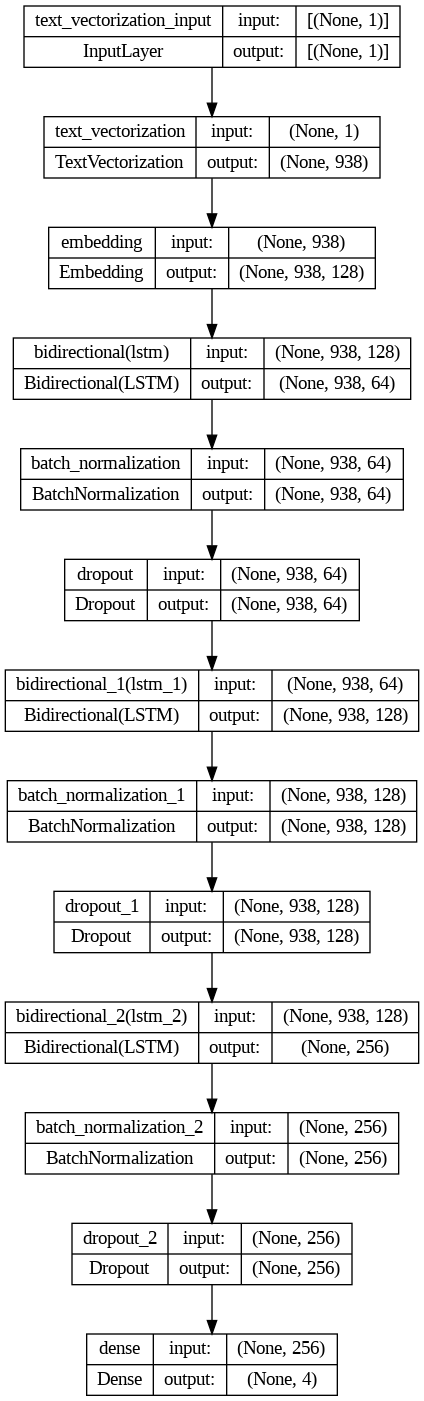

In [212]:
# Plot layers

tf.keras.utils.plot_model(model2, show_shapes=True)

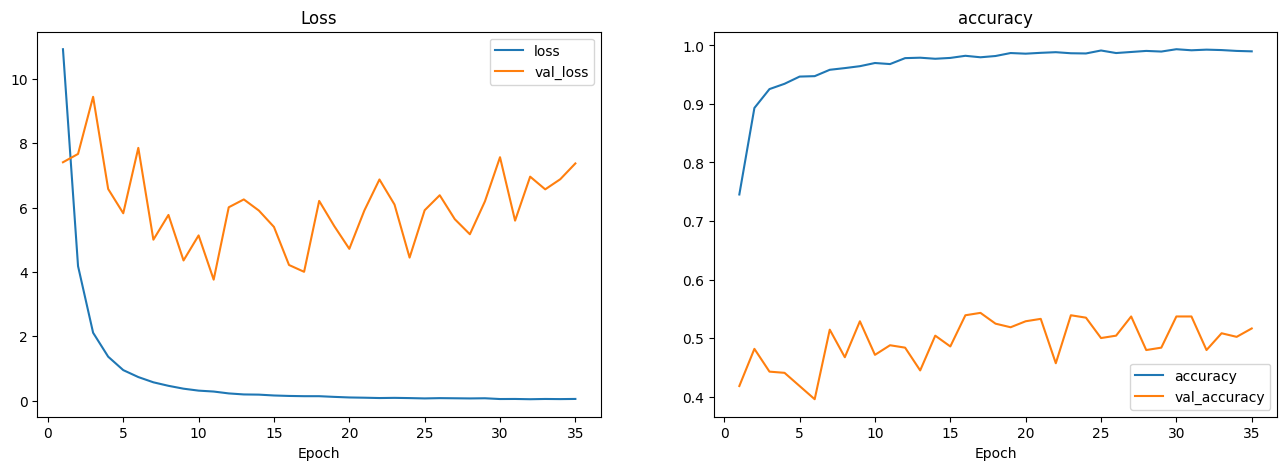

In [211]:
# Evaluation of the model

metrics2 = pd.DataFrame(model_dnn_hist_2.history)

# Evaluate the loss and accuracy of the model
epoch=35

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),model_dnn_hist_2.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),model_dnn_hist_2.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),model_dnn_hist_2.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),model_dnn_hist_2.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

- Pada improvement kali ini, hasil latih model menunjukkan bahwa model sudah belajar dengan baik
- Namun pada hasil validasinya, model masih belum bisa memprediksikan sebaik saat training, namun nilai `akurasi` dari validasi model kali ini `sudah meningkat` yakni dari nilai 0.2 naik ke range 0.4 hingga 0.5, yang berarti dengan penambahan bidirectional, pembobotan kernel dan recurrent, serta perubahan optimizer sudah mempengaruhi performansi model
- Model masih overfit dengan nilai dibawah 50%, sehingga model ini belum sepenuhnya dapat dipercaya sepenuhnya untuk memprediksikan rating dari pengunjung

In [142]:
# Model Evaluation of test-set
y_pred2 = model2.predict(X_test)
y_pred2

18/18 [==============================] - 3s 63ms/step


array([[5.97987224e-08, 1.38646691e-10, 3.00000602e-06, 9.99996901e-01],
       [1.17579356e-19, 5.23207673e-37, 0.00000000e+00, 1.00000000e+00],
       [3.91532389e-08, 1.01342739e-05, 1.68929711e-01, 8.31060052e-01],
       ...,
       [8.75725806e-01, 1.24267422e-01, 6.60045589e-06, 1.54990289e-07],
       [2.28687073e-03, 9.95397985e-01, 2.30294489e-03, 1.22733845e-05],
       [3.77377984e-03, 2.29645371e-01, 3.04636300e-01, 4.61944550e-01]],
      dtype=float32)

In [143]:
# get the real prediction of a target
y_pred_new2=[]

for i in range (len(y_pred2)):
  y_pred_new2.append(np.array(y_pred2[i]).argmax())

y_pred_new2=np.array(y_pred_new2)

In [144]:
# Classification report of the model
print (classification_report(y_test, y_pred_new2))

              precision    recall  f1-score   support

           0       0.70      0.55      0.62       162
           1       0.37      0.51      0.43       112
           2       0.54      0.39      0.45       145
           3       0.61      0.74      0.66       155

    accuracy                           0.55       574
   macro avg       0.55      0.55      0.54       574
weighted avg       0.57      0.55      0.55       574



- Nilai akurasi masih kecil, namun sudah di atas 50% yang artinya, jika kita memiliki 2 data, ada kemungkinan dimana model bisa memprediksi 1 di antara 2 data tersebut yang benar, satu lagi tidak dapat diprediksikan dengan benar.
- Model lebih buruk saat memprediksi target rating 1 dan 2 sedangkan lebih baik saat memodelkan rating 0 dan 3 dilihat berdasarkan nilai presisi, recall, dan f1-score pada report di atas

\
__Kesimpulan__
- Model kami sudah mendapatkan peningkatan performansi setelah dilakukan penyesuaian terhadap layer serta menggunakan wrapper bidirectional
- Berdasarkan proses yg kami lakukan terhadap data, terdapat beberapa data yang bukan dalam bahasa inggris, sehingga model kami juga `belum dapat` memprediksikan review yang bukan dalam bahasa inggris **`(kekurangan)`**. Kekurangan model kami juga, akan lebih cenderung salah saat memodelkan target yang seharusnya memiliki rating 1 atau 2.
- Data yang kami gunakan adalah sample dari data review hotel London tanpa mempedulikan lokasi, nama, orang, dan metadata lainnya sehingga model ini dapat diaplikasikan ke data review hotel selain di London **`(kelebihan)`**. Kelebihan model kami juga model sudah dapat memprediksikan target 0 atau 3.

__Saran__
- Untuk peningkatan model selanjutnya, diduga karena data yang susah (dari segi jumlah dan kekayaan vocabularies), menyebabkan model terlalu sulit untuk menebak data baru, sehingga perlu dilakukan proses cleaning tambahan seperti membuang 20% most frequent data atau 20% least frequent data (yg mana harus dicek terlebih dahulu pengaruhnya terhadap sentiment kalimat yang digunakan). Penambahan wrapper sangat membantu meningkatkan performa model sehingga kami menyarankan untuk tetap menggunakan wrapper ini saat melakukan trial untuk improvisasi selanjutnya.

## Model Saving

Berdasarkan evaluasi model base dan model improvement, kami mendapati bahwa model terbaik yang akan kami pakai adalah model hasil improvement, yakni model2.

In [213]:
# Freeze Model
model2.trainable = False
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 938)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 938, 128)          1387520   
                                                                 
 bidirectional (Bidirectiona  (None, 938, 64)          41216     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 938, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 938, 64)           0         
                                                        

In [215]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
# Save LSTM Model

model2.save('/content/drive/MyDrive/model_lstm_hotel')

## Conclusions

-  Pengunjung biasanya memberikan rating paling sering jika mendapatkan pelayanan yang memuaskan, sedangkan ketika tidak mendapatkan pelayanan yang memuaskan, mereka lebih memilih untuk tidak memberikan review
- Semakin kecil rating yang diberikan oleh pengunjung, semakin banyak rata-rata kalimat dan kata-kata review yang diberikan ke hotel tersebut, dan semakin banyak sentiment negatif yang diberikan ke dalam review. 
- Hotel dengan rate yang tinggi cenderung memiliki sentiment review yang positif, sedangkan hotel dengan rate yang rendah, yakni rate 0, memiliki sentiment review yang negatif jika dibandingkan dari hotel dengan rate lain
- Kebanyakan pengunjung memberi review yang bersifat positif dibandingkan review yang bersifat negatif
*   Model terbaik yang didapat adalah model sequential dengan wrapper LSTM, yakni bidirectional dengan penambahan dropout, batch normalization, dan pembobotan terhadap kernel dan recurrent



## Resources : 
https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/